In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,75430,None,None,86085.715275
2020-06-13,75431,None,None,79940.811469
2020-06-14,75432,None,None,74244.112992
2020-06-15,75433,None,None,68878.187593
2020-06-16,75434,None,None,64137.552455
...,...,...,...,...
2021-06-30,75813,None,None,320759.929166
2021-07-01,75814,None,None,333758.789067
2021-07-02,75815,None,None,346833.171425


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-04_2021-07-04-18-53.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-03_2021-07-03-19-20.pickle


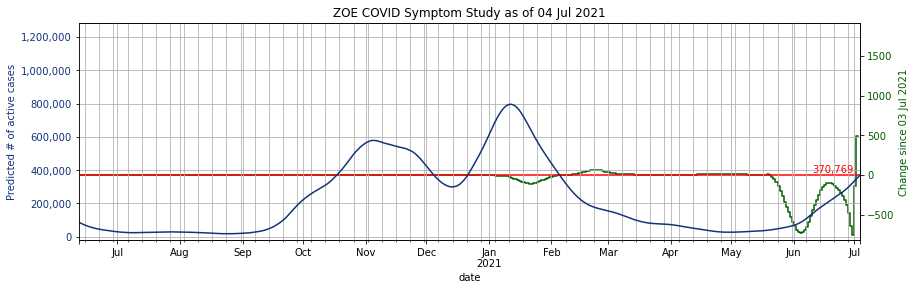

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

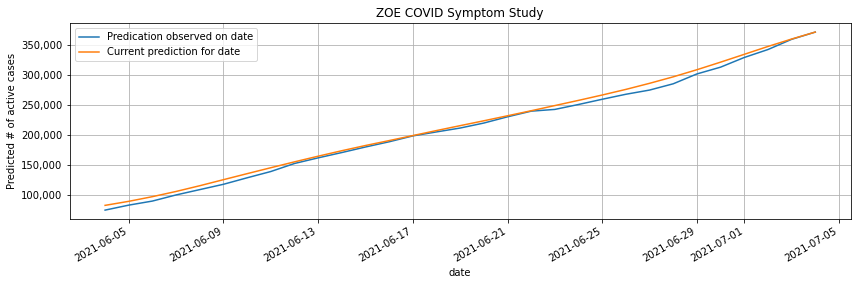

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-07-04_2021-07-04-18-54.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
293,East Lothian,S12000010,2.092827
170,Lancaster,E07000121,2.079241
313,Aberdeen City,S12000033,2.055212
289,Dumfries and Galloway,S12000006,1.838434
274,Wigan,E08000010,1.781160
267,Bury,E08000002,1.740957
308,Perth and Kinross,S12000024,1.734418
325,Glasgow City,S12000046,1.733294
321,Angus,S12000041,1.612287
295,East Renfrewshire,S12000011,1.556406
